In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def read_roc(dir_path: str):
    roc = {}
    for target in ['minor', 'important', 'full', 'all']:
        roc[target] = np.load(os.path.join(dir_path, 'ROC_{}.npy'.format(target)), allow_pickle=True)
    return roc

control_roc = read_roc('../output/control')
miNNseq_roc = read_roc('../output/miNNseq')
regression_control_roc = read_roc('../output/regression_control')

In [3]:
def lineplot(data, x=None, y=None, hue=None, xticklabels=None, output_path: str = None, figsize: tuple = (24, 12)):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.lineplot(data=data, x=x, y=y, hue=hue)
    ax = sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='red')

    plt.legend(loc='lower right')
    plt.grid(False)

    if x:
        plt.xlabel(x)
    if y:
        plt.ylabel(y)
    if xticklabels:
        ax.set_xticklabels(labels=xticklabels)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()

In [4]:
def plot(roc, output_dir=None):
    for target in ['minor', 'important', 'full', 'all']:
        methods_result = roc[target].item()

        _rocs = pd.DataFrame()
        for method_name in methods_result.keys():
            _xs, _ys = methods_result[method_name][0], methods_result[method_name][1]

            tprs = []
            mean_fpr = np.linspace(0, 1, 100)
            for i in range(len(_xs)):
                _x, _y = _xs[i], _ys[i]
                interp_tpr = np.interp(mean_fpr, _x, _y)
                interp_tpr[0], interp_tpr[-1] = 0.0, 1
                _tprs = interp_tpr.tolist()
                tprs.extend(_tprs)

            _df = pd.DataFrame({
                'FPR': mean_fpr.tolist() * len(_xs), 'TPR': tprs,
                'method': '{}(AUC={})'.format(method_name, round(np.mean(methods_result[method_name][2]), 2))
            })
            _rocs = pd.concat([_rocs, _df])
        _rocs.reset_index(drop=True, inplace=True)

        lineplot(
            _rocs,
            x='FPR',
            y='TPR',
            hue='method',
            output_path='{}/ROC({}).pdf'.format(output_dir, target) if output_dir else None,
            figsize=(8, 8)
        )

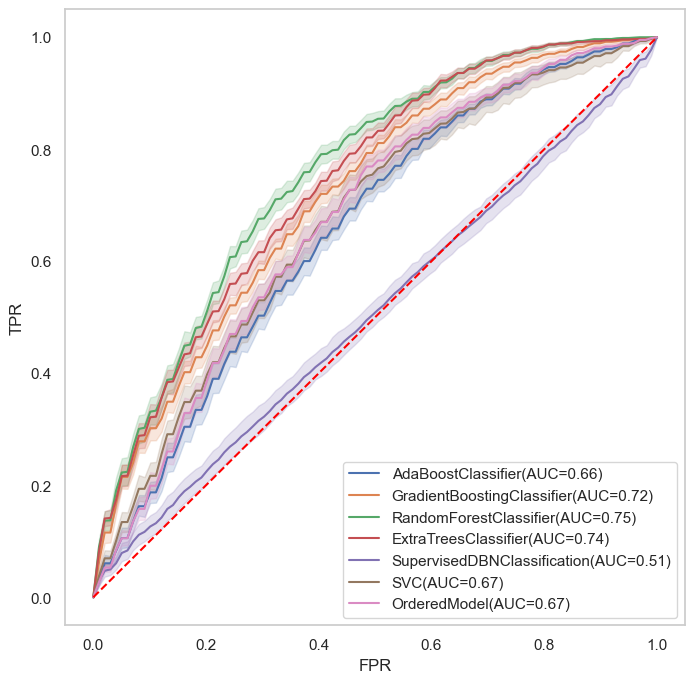

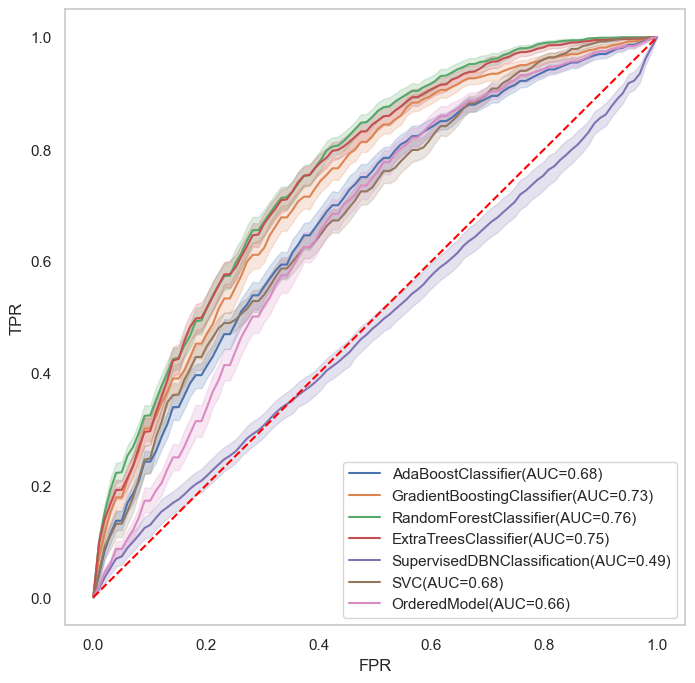

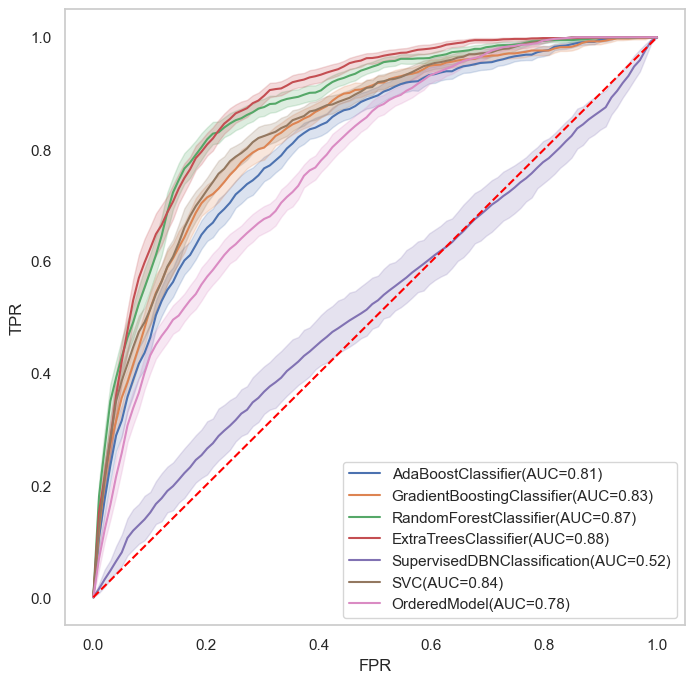

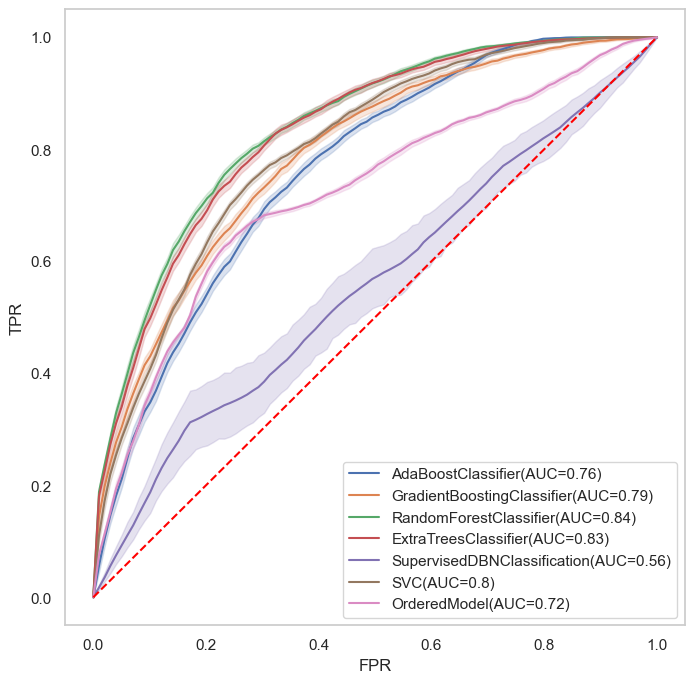

In [5]:
plot(control_roc, '../output/control')

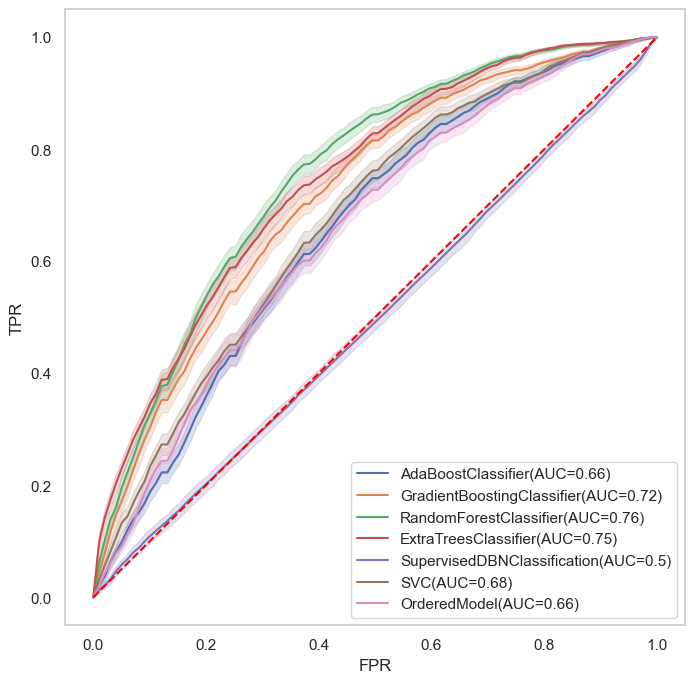

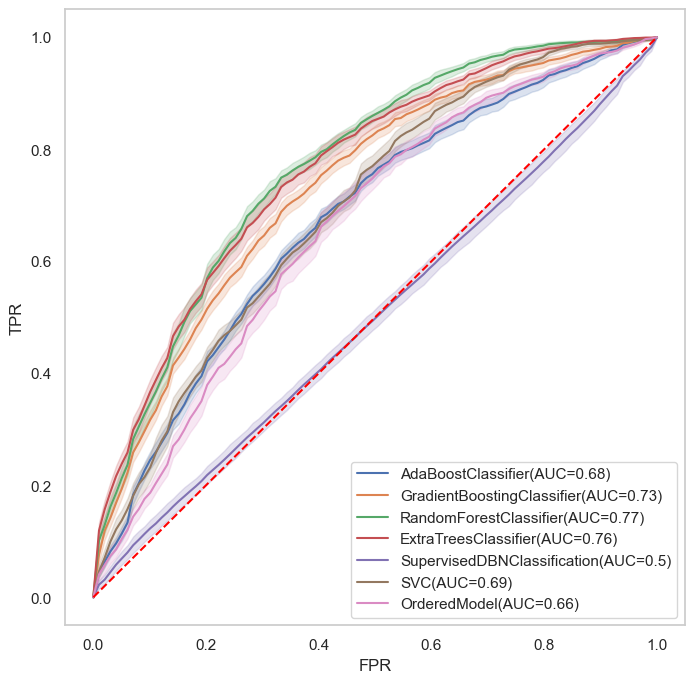

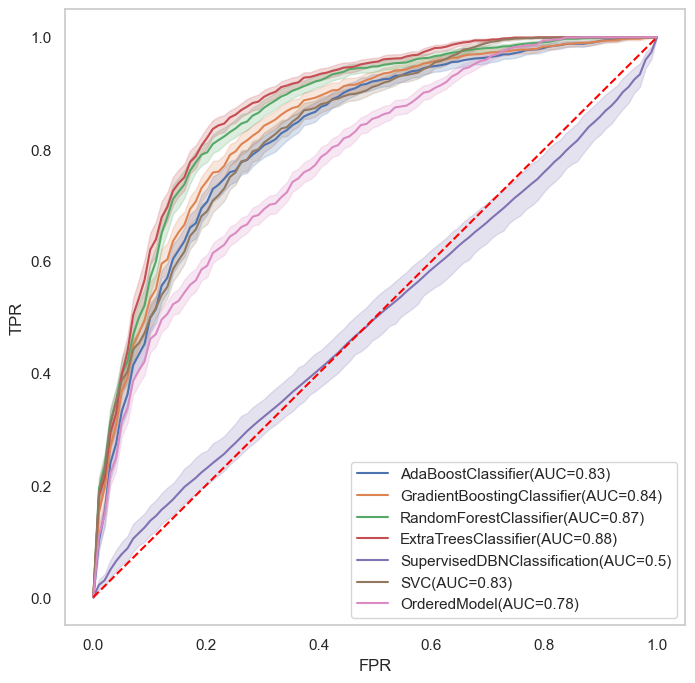

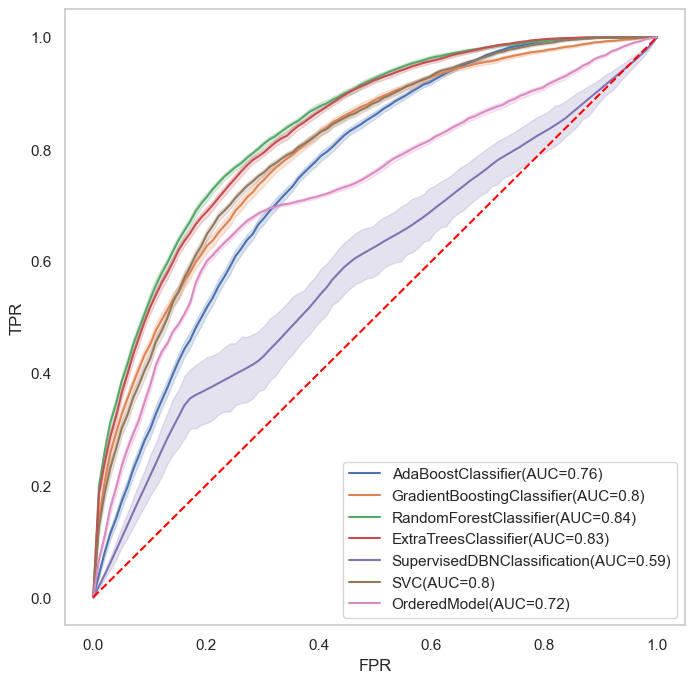

In [6]:
plot(miNNseq_roc, '../output/miNNseq')

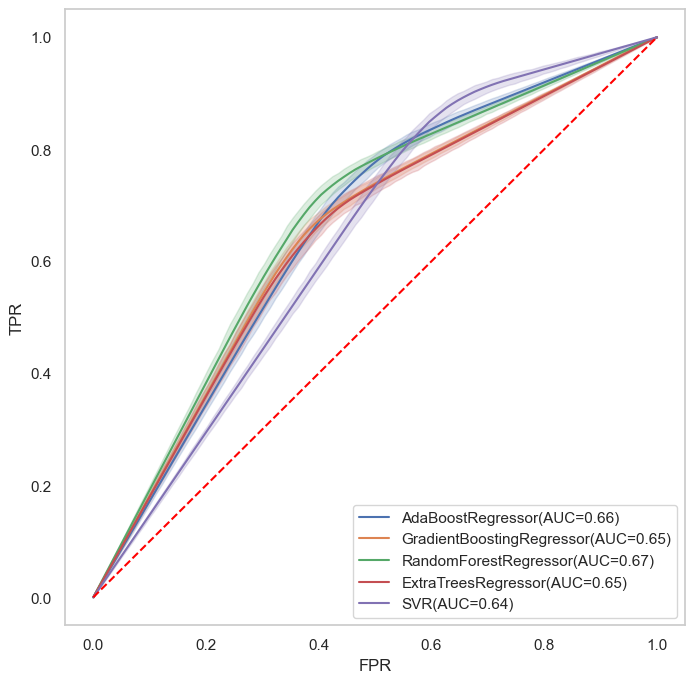

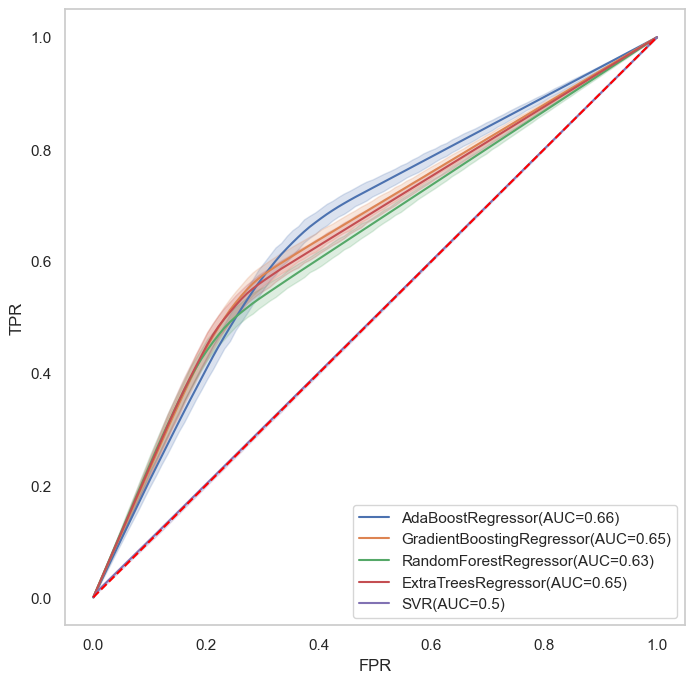

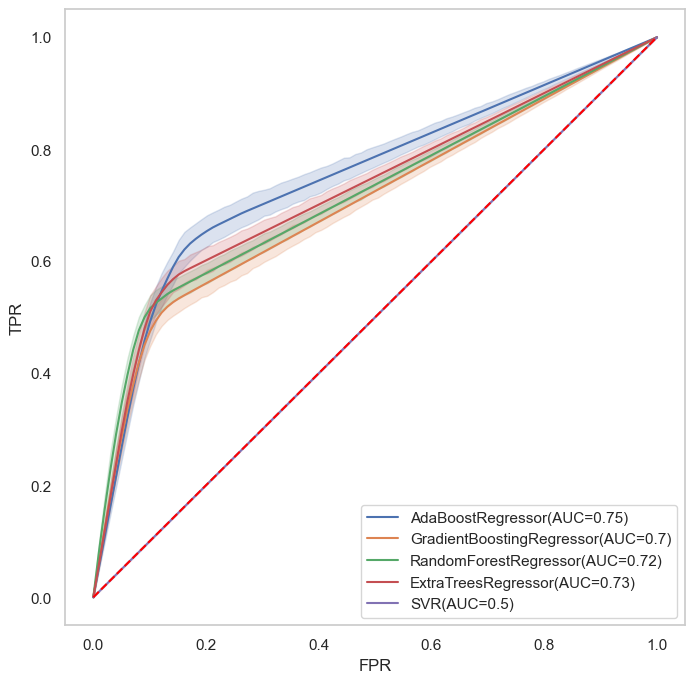

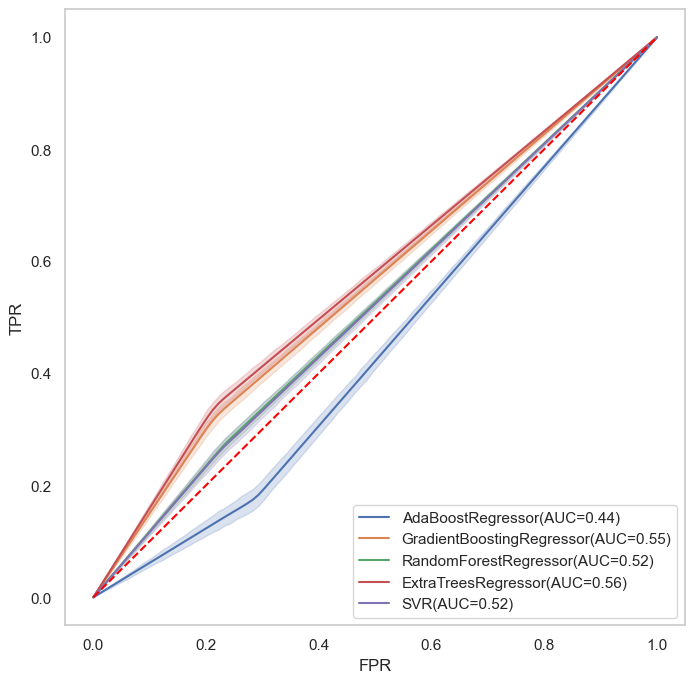

In [7]:
plot(regression_control_roc, '../output/regression_control')

In [8]:
def read_accuracy(dir_path: str):
    acc = {}
    for target in ['minor', 'important', 'full', 'all']:
        acc[target] = pd.read_csv(os.path.join(dir_path, 'accuracy_{}.csv'.format(target)), index_col=0)
    return acc

control_acc = read_accuracy('../output/control')
miNNseq_acc = read_accuracy('../output/miNNseq')
regression_control_acc = read_accuracy('../output/regression_control')

In [9]:
def get_comprehensive_comparison(acc, roc):
    acc_result = pd.DataFrame()
    for target in ['minor', 'important', 'full', 'all']:
        _acc = pd.DataFrame(acc[target].mean(), columns=[target])
        _acc = (round(_acc * 100, 2)).astype(str)
        _acc[target] += '±' + (round(acc[target].std() * 100, 2)).astype(str)
        acc_result = pd.concat([acc_result, _acc], axis=1)
    acc_result.columns = pd.MultiIndex.from_product([['Accuracy(%)'], acc_result.columns])

    roc_auc_result = pd.DataFrame()
    for target in ['minor', 'important', 'full', 'all']:
        _roc = roc[target].item()
        _roc_auc = [
            roc[target].item()[key][2]
            for key in _roc.keys()
        ]
        _roc_auc = pd.DataFrame(_roc_auc, index=_roc.keys())
        _auc = pd.DataFrame(_roc_auc.mean(axis=1), columns=[target])
        _auc = (round(_auc, 2)).astype(str)
        _auc[target] += '±' + (round(_roc_auc.std(axis=1), 2)).astype(str)
        roc_auc_result = pd.concat([roc_auc_result, _auc], axis=1)
    roc_auc_result.columns = pd.MultiIndex.from_product([['ROC-AUC'], roc_auc_result.columns])

    comprehensive_result = pd.concat([acc_result, roc_auc_result], axis=1)
    return comprehensive_result

In [10]:
comprehensive_result = get_comprehensive_comparison(control_acc, control_roc)
comprehensive_result.to_csv('../output/control/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                      \
                                  minor   important        full         all   
AdaBoostClassifier           61.31±4.25  65.14±3.85  80.34±2.55  49.41±4.88   
GradientBoostingClassifier   65.25±3.27  67.54±3.49  81.89±2.59   53.7±3.39   
RandomForestClassifier       69.04±3.25   69.04±3.3  83.71±2.32  59.54±3.02   
ExtraTreesClassifier         66.99±2.96  69.36±2.92  84.29±2.78  58.16±3.25   
SupervisedDBNClassification    50.4±0.0    62.4±0.0    78.4±0.0    49.6±0.0   
SVC                          59.68±3.45    62.4±0.0    78.4±0.0   48.9±1.16   
OrderedModel                  62.85±4.3  62.27±2.82  79.54±1.66  49.47±1.12   

                               ROC-AUC                                   
                                 minor  important       full        all  
AdaBoostClassifier           0.66±0.04  0.68±0.04  0.81±0.04  0.76±0.02  
GradientBoostingClassifier   0.72±0.03  0.73±0.04  0.83±0.04  0.79±0.02  
RandomForestClassifier       0.75±0.03  0.76±0.03  0.87±0.04  0.84±0.01  
ExtraTreesClassifier         0.74±0.03  0.75±0.04  0.88±0.03  0.83±0.02  
SupervisedDBNClassification  0.51±0.07  0.49±0.07  0.52±0.13  0.56±0.12  
SVC                          0.67±0.07  0.68±0.04  0.84±0.03   0.8±0.01  
OrderedModel                 0.67±0.04  0.66±0.05  0.78±0.04  0.72±0.01

In [11]:
comprehensive_result = get_comprehensive_comparison(miNNseq_acc, miNNseq_roc)
comprehensive_result.to_csv('../output/miNNseq/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                      \
                                  minor   important        full         all   
AdaBoostClassifier            61.96±3.4   65.3±2.48  81.06±2.49   48.34±4.1   
GradientBoostingClassifier   66.36±3.28  69.48±2.33   82.1±2.31   54.43±3.0   
RandomForestClassifier       69.74±3.17  70.87±2.73  83.13±1.99   59.4±2.45   
ExtraTreesClassifier         67.82±2.93  71.07±3.01  83.57±2.07  58.27±2.58   
SupervisedDBNClassification   50.56±0.0   63.33±0.0   78.89±0.0   50.56±0.0   
SVC                          61.86±2.93   63.33±0.0   78.89±0.0  50.22±1.03   
OrderedModel                 60.73±3.41   63.2±1.86  80.84±1.82  50.78±1.22   

                               ROC-AUC                                   
                                 minor  important       full        all  
AdaBoostClassifier           0.66±0.03  0.68±0.03  0.83±0.03  0.76±0.02  
GradientBoostingClassifier   0.72±0.04  0.73±0.03  0.84±0.03   0.8±0.02  
RandomForestClassifier       0.76±0.04  0.77±0.03  0.87±0.03  0.84±0.01  
ExtraTreesClassifier         0.75±0.03  0.76±0.03  0.88±0.02  0.83±0.01  
SupervisedDBNClassification   0.5±0.04   0.5±0.05    0.5±0.1  0.59±0.12  
SVC                          0.68±0.04  0.69±0.03  0.83±0.03   0.8±0.01  
OrderedModel                 0.66±0.04  0.66±0.04  0.78±0.03  0.72±0.01

In [12]:
comprehensive_result = get_comprehensive_comparison(regression_control_acc, regression_control_roc)
comprehensive_result.to_csv('../output/regression_control/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                      \
                                minor   important        full         all   
AdaBoostRegressor           65.92±2.9  66.29±3.92  81.84±3.14  16.64±5.44   
GradientBoostingRegressor   64.74±2.8  67.36±3.76  81.78±2.85  32.59±3.48   
RandomForestRegressor      67.26±3.28   67.2±3.18   83.36±2.6  28.03±2.83   
ExtraTreesRegressor        64.59±3.79   67.5±3.35   82.35±2.8  34.46±3.66   
SVR                        64.14±3.26  62.35±0.96    78.4±0.0  27.76±3.87   

                             ROC-AUC                                   
                               minor  important       full        all  
AdaBoostRegressor          0.66±0.03  0.66±0.04  0.75±0.05  0.44±0.04  
GradientBoostingRegressor  0.65±0.03  0.65±0.04   0.7±0.05  0.55±0.02  
RandomForestRegressor      0.67±0.03  0.63±0.03  0.72±0.04  0.52±0.02  
ExtraTreesRegressor        0.65±0.04  0.65±0.04  0.73±0.05  0.56±0.02  
SVR                        0.64±0.03   0.5±0.01    0.5±0.0  0.52±0.03